## Пет-Проект: пишем парсер вакансий

### цели проекта:

- первая и самая важная цель: оптимизировать свой собственный поиск работы:
    отобрать максимально релевантные вакансии (хард скилы, опыт) (я ищу вакансии для специалистов без опыта, с использованием sql и python для анализа данных)
- вторая цель: посмотреть, что у нас на рынке труда сегодня? (кого куда хотят и с каким скилами)
- третья цель не менее важная: освежить все свои навыки аналитики

### задачи:

- задать параметры по вакансиям (провессия, навыки и т.д.)
- написать парсер для сайта hh.ru
- обработать данные (пропуски, дубликаты и прочее)
- провести EDA (статистики, выбросы, предположения)
- ГРАФИКИ
- где-то тут должны появиться еще несколько хороших идей
- формулировка гипотез и их статистическаф проверка
- выводы 
- рекомендации

### Импорт библиотек

In [1]:
import requests
import pandas as pd
import numpy as np

import json

from datetime import datetime, timedelta
import time
import os
from IPython.core.display import display, HTML, clear_output
import ipywidgets as widgets
from typing import Union

import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\aglagoleva\AppData\Local\Temp\ipykernel_18348\2055726921.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, clear_output
C:\Users\aglagoleva\AppData\Local\Temp\ipykernel_18348\2055726921.py:10: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, clear_output


### Делаем выгрузку из HeadHunter
Ссылка на API HH: https://github.com/hhru/api \
Для того, чтобы написать запрос используется язык поисковых запросов, задокументированный тут: https://hh.ru/article/1175 \
Фильтрацию можно делать в самом запросе, например, сделать поиск по полю компаний или же по наличию конкретного текста в описании, где COMPANY_NAME - название компании, а DESCRIPTION - описание вакансии. Язык запросов работает и на обычном сайте hh.ru, что бывает полезно.

Создадим необходимые константы: BASE_URL

In [2]:
BASE_URL = "https://api.hh.ru/"

#TEXT = f'NAME:("Machine Learning Engineer" OR "Data Scientist" OR "Дата саентист" OR "Machine Learning Developer" or "Machine Learning Researcher" or "Искусственный интеллект" or "Машинное обучение" or "Специалист по machine learning" or "Специалист по машинному обучению" or "AI engineer" or "Разработчик ML" or "Data Science" or "Machine Learning" or "Artificial Intelligence" or "ML Engineer" or "Аналитик" or "Analyst" or "Data Engineer" or "DWH" or "BI" or "Business Intelligence" or "Data инженер" or "Инженер данных" or "ETL" or "КХД")'
TEXT = f'SQL NAME:("Аналитик" or "Analyst" or "DWH" or "BI" or "Business Intelligence" or "ETL" or "КХД")'

dt_now = datetime.now().date()
dt_from = dt_now - timedelta(days=7)
DATE_TO = dt_now.isoformat() #API требует дату в формате ISO 8601 YYYY-MM-DD или YYYY-MM-DDThh:mm:ss±hhmm
DATE_FROM = dt_from.isoformat()

VAC_URL = BASE_URL + f'vacancies?text={TEXT}&date_from={DATE_FROM}&date_to={DATE_TO}&responses_count_enabled=True&per_page=100'

In [3]:
vacancy_df = pd.DataFrame() # создаем датафрейм в который будем сохранять наши данные

В выдаче API HH нет опыта работы, поэтому мы укажем его в запросе самостоятельно:\
Можно выбрать подходящий. Важно помнить, что можно откликаться на вакансии «от 1 года опыта» :)

In [4]:
experiences = ['noExperience',
               'between1And3',
               'between3And6', 
               'moreThan6']

#### Напишем цикл для направления запросов к API (в 3 этапа: get, json и перебор страниц)

In [5]:
for exp in experiences:
    page = 0
    url = VAC_URL + f'&experience={exp}'
    try:
        r = requests.get(url +f'&page={page}')
        data = json.loads(r.text)
        print(exp,' - ', data['pages'])
        items = data['items']
        for page in range(1,data['pages']):
            r = requests.get(url+f'&page={page}')
            data = json.loads(r.text)
            items += data['items']
        df = pd.DataFrame(items)
        df['experience'] = exp
        vacancy_df = pd.concat([vacancy_df, df])
    except Exception as e:
        print(exp, ' - ', e)
        time.sleep(10)

noExperience  -  1
between1And3  -  10
between3And6  -  8
moreThan6  -  1


In [6]:
vacancy_df

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,...,employer,snippet,contacts,schedule,counters,working_days,working_time_intervals,working_time_modes,accept_temporary,experience
0,70410506,False,Архитектор DWH,None,False,False,"{'id': '160', 'name': 'Алматы', 'url': 'https:...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,"{'id': '23817', 'name': 'Народный банк Казахст...",{'requirement': 'Продвинутое знание <highlight...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 0},[],[],[],False,noExperience
1,67116979,False,Аналитик,None,False,False,"{'id': '4', 'name': 'Новосибирск', 'url': 'htt...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Новосибирск', 'street': 'улица Киров...",...,"{'id': '766468', 'name': 'Группа компаний С7',...",{'requirement': 'Знать основные инструменты (н...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 2},[],[],[],False,noExperience
2,67116978,False,Аналитик,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'улица Петровка',...",...,"{'id': '766468', 'name': 'Группа компаний С7',...",{'requirement': 'Знать основные инструменты (н...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 8},[],[],[],False,noExperience
3,45447918,False,SQL-аналитик,None,False,False,"{'id': '63', 'name': 'Саранск', 'url': 'https:...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Саранск', 'street': 'Большевистская ...",...,"{'id': '1416056', 'name': 'Инфомаксимум', 'url...",{'requirement': 'Способен вести деловые перего...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 3},[],[],[],False,noExperience
4,69716290,False,Бизнес-аналитик,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Замоскворецкая л...",...,"{'id': '4482374', 'name': 'Медиапоинт', 'url':...","{'requirement': 'Знание AGILE. Знание JAVA, PH...",None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 274},[],[],[],False,noExperience
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,70056397,False,Архитектор BI,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,"{'id': '64474', 'name': 'GlowByte', 'url': 'ht...",{'requirement': '...архитектора с использовани...,None,"{'id': 'flexible', 'name': 'Гибкий график'}",{'responses': 5},[],[],[],False,moreThan6
26,70092569,False,Главный специалист по клиентской аналитике,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Рочдельская улиц...",...,"{'id': '4309', 'name': 'Ингосстрах', 'url': 'h...",{'requirement': 'Навыки работы с базами данных...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 6},[],[],[],False,moreThan6
27,66930328,False,Ведущий системный аналитик (senior/middle),None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 200000, 'to': 400000, 'currency': 'RU...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': '2-я Магистральна...",...,"{'id': '5077661', 'name': 'РТ КИС', 'url': 'ht...",{'requirement': 'Опыт построения баз данных (<...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 0},[],[],[],False,moreThan6
28,70097234,False,Руководитель группы продуктовой и маркетингово...,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Профсоюзная улиц...",...,"{'id': '32918', 'name': 'MANGO OFFICE', 'url':...",{'requirement': 'Высшее образование (математич...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 10},[],[],[],False,moreThan6


In [7]:
vacancy_df.reset_index(drop = True, inplace = True)
vacancy_df.head()

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,...,employer,snippet,contacts,schedule,counters,working_days,working_time_intervals,working_time_modes,accept_temporary,experience
0,70410506,False,Архитектор DWH,None,False,False,"{'id': '160', 'name': 'Алматы', 'url': 'https:...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,"{'id': '23817', 'name': 'Народный банк Казахст...",{'requirement': 'Продвинутое знание <highlight...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 0},[],[],[],False,noExperience
1,67116979,False,Аналитик,None,False,False,"{'id': '4', 'name': 'Новосибирск', 'url': 'htt...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Новосибирск', 'street': 'улица Киров...",...,"{'id': '766468', 'name': 'Группа компаний С7',...",{'requirement': 'Знать основные инструменты (н...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 2},[],[],[],False,noExperience
2,67116978,False,Аналитик,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'улица Петровка',...",...,"{'id': '766468', 'name': 'Группа компаний С7',...",{'requirement': 'Знать основные инструменты (н...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 8},[],[],[],False,noExperience
3,45447918,False,SQL-аналитик,None,False,False,"{'id': '63', 'name': 'Саранск', 'url': 'https:...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Саранск', 'street': 'Большевистская ...",...,"{'id': '1416056', 'name': 'Инфомаксимум', 'url...",{'requirement': 'Способен вести деловые перего...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 3},[],[],[],False,noExperience
4,69716290,False,Бизнес-аналитик,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Замоскворецкая л...",...,"{'id': '4482374', 'name': 'Медиапоинт', 'url':...","{'requirement': 'Знание AGILE. Знание JAVA, PH...",None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 274},[],[],[],False,noExperience


In [13]:
vacancy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1798 entries, 0 to 1797
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        1798 non-null   object
 1   premium                   1798 non-null   bool  
 2   name                      1798 non-null   object
 3   department                288 non-null    object
 4   has_test                  1798 non-null   bool  
 5   response_letter_required  1798 non-null   bool  
 6   area                      1798 non-null   object
 7   salary                    372 non-null    object
 8   type                      1798 non-null   object
 9   address                   880 non-null    object
 10  response_url              0 non-null      object
 11  sort_point_distance       0 non-null      object
 12  published_at              1798 non-null   object
 13  created_at                1798 non-null   object
 14  archived                

### Вытащим ценную информацию из словарей

Напишем функцию

In [8]:
def return_id(x, key = 'id', nan_value = np.nan):
    try:
        return x[key]
    except Exception as e:
        return nan_value
    

In [9]:
vacancy_df['employer_name'] = vacancy_df['employer'].apply(return_id, key = 'name')
vacancy_df['department_name'] = vacancy_df['department'].apply(return_id, key = 'name')
vacancy_df['salary_from'] = vacancy_df['salary'].apply(return_id, key = 'from')
vacancy_df['salary_to'] = vacancy_df['salary'].apply(return_id, key = 'to')
vacancy_df['salary_currency'] = vacancy_df['salary'].apply(return_id, key = 'currency')
vacancy_df['salary_gross'] = vacancy_df['salary'].apply(return_id, key = 'gross')
vacancy_df['responses'] = vacancy_df['counters'].apply(return_id, key = 'responses')
vacancy_df['city'] = vacancy_df['area'].apply(return_id, key = 'name')

In [10]:
vacancy_df.head()

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,...,accept_temporary,experience,employer_name,department_name,salary_from,salary_to,salary_currency,salary_gross,responses,city
0,70410506,False,Архитектор DWH,None,False,False,"{'id': '160', 'name': 'Алматы', 'url': 'https:...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,False,noExperience,Народный банк Казахстана,NaN,NaN,NaN,NaN,NaN,0,Алматы
1,67116979,False,Аналитик,None,False,False,"{'id': '4', 'name': 'Новосибирск', 'url': 'htt...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Новосибирск', 'street': 'улица Киров...",...,False,noExperience,Группа компаний С7,NaN,NaN,NaN,NaN,NaN,2,Новосибирск
2,67116978,False,Аналитик,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'улица Петровка',...",...,False,noExperience,Группа компаний С7,NaN,NaN,NaN,NaN,NaN,8,Москва
3,45447918,False,SQL-аналитик,None,False,False,"{'id': '63', 'name': 'Саранск', 'url': 'https:...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Саранск', 'street': 'Большевистская ...",...,False,noExperience,Инфомаксимум,NaN,NaN,NaN,NaN,NaN,3,Саранск
4,69716290,False,Бизнес-аналитик,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Замоскворецкая л...",...,False,noExperience,Медиапоинт,NaN,NaN,NaN,NaN,NaN,274,Москва


Вытащим желаемые данные

### Про дубликаты

In [11]:
vacancy_df[vacancy_df.duplicated(['employer_name', 'name', 'city'], keep =False)][
    ['employer_name', 'name', 'city', 'experience']].sort_values(by='name')

,employer_name,name,city,experience
1268,WILDBERRIES,BI Developer,Москва,between3And6
1269,WILDBERRIES,BI Developer,Москва,between3And6
99,WILDBERRIES,BI аналитик,Москва,between1And3
100,WILDBERRIES,BI аналитик,Москва,between1And3
74,Лига Цифровой Экономики,Аналитик,Москва,between1And3
455,Лига Цифровой Экономики,Аналитик,Москва,between1And3
669,СБЕР,Аналитик,Екатеринбург,between1And3
498,СБЕР,Аналитик,Екатеринбург,between1And3
56,СБЕР,Аналитик DWH,Москва,between1And3
58,СБЕР,Аналитик DWH,Москва,between1And3


In [13]:
vacancy_df.loc[[1134,1675]]

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,...,accept_temporary,experience,employer_name,department_name,salary_from,salary_to,salary_currency,salary_gross,responses,city
1134,70405322,False,Финансовый аналитик в Маркет,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': None, 'street': None, 'building': Non...",...,False,between3And6,Яндекс,NaN,NaN,NaN,NaN,NaN,28,Москва
1675,70019241,False,Финансовый аналитик в Маркет,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Новинский бульва...",...,False,between3And6,Яндекс,NaN,NaN,NaN,NaN,NaN,219,Москва


### Посмотрим компании, предлагающие вакансии, а также города

<AxesSubplot:>

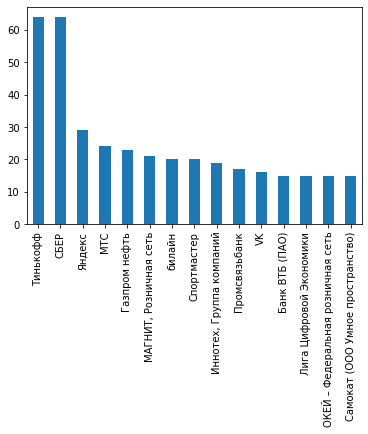

In [14]:
vacancy_df['employer_name'].value_counts().head(15).plot(kind='bar')

<AxesSubplot:>

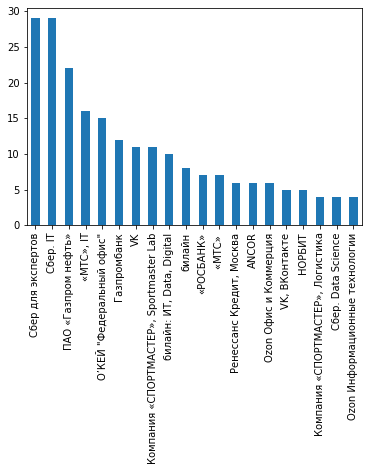

In [15]:
vacancy_df['department_name'].value_counts().head(20).plot(kind='bar')

<AxesSubplot:>

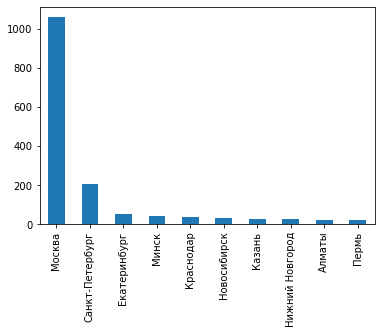

In [16]:
vacancy_df['city'].value_counts().head(10).plot(kind='bar')

### Что с зарплатой?

In [17]:
vacancy_df['salary_from'].isna().value_counts(normalize = True)

True     0.839408
False    0.160592
Name: salary_from, dtype: float64

In [18]:
vacancy_df['salary_to'].isna().value_counts(normalize = True)

True     0.870159
False    0.129841
Name: salary_to, dtype: float64

In [19]:
vacancy_df['salary_currency'].value_counts(normalize = True)

RUR    0.903683
USD    0.031161
KZT    0.028329
BYR    0.019830
EUR    0.011331
UZS    0.005666
Name: salary_currency, dtype: float64

In [20]:
salaries = (vacancy_df
            .query('salary_currency == "RUR" and experience in ["noExperience", "between1And3"]')
            .groupby(['employer_name', 'department_name'])
            .mean()['salary_from']
            .reset_index())
salaries

,employer_name,department_name,salary_from
0,"ДИКСИ, группа компаний",ДИКСИ. Офис,120000.0
1,ЛЭтуаль,Л'Этуаль Логистический центр,50000.0
2,МТС,«МТС»,50000.0
3,Спортмастер,"Компания «СПОРТМАСТЕР», Логистика",70000.0
4,Спортмастер,"Компания «СПОРТМАСТЕР», Розничные продажи",75000.0
5,Спортмастер,"Компания «СПОРТМАСТЕР», Управление бизнесами",150000.0


Визуализируем с помощью seaborn

<AxesSubplot:xlabel='employer_name', ylabel='salary_from'>

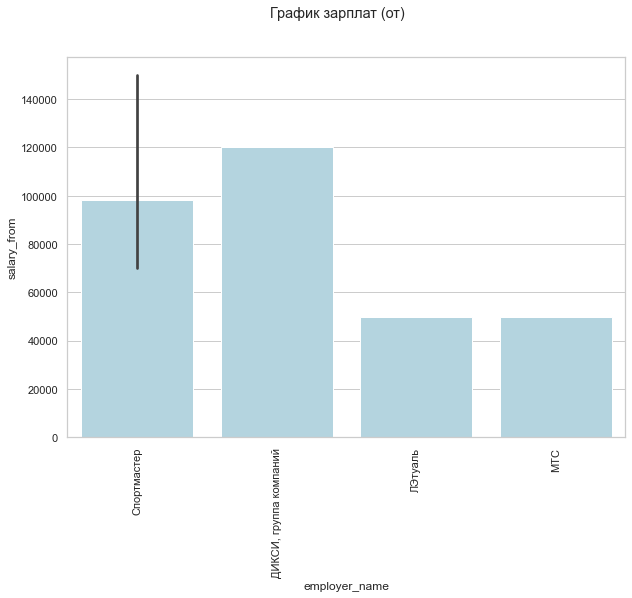

In [21]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(10,7))                
title = 'График зарплат (от)'
fig.suptitle(title)
plt.xticks(rotation=90)  
sns.barplot(data=salaries.sort_values(by='salary_from', ascending=False), x='employer_name', y='salary_from', color='lightblue', ax=ax)

Удалим пропуски в 'employer_name', 'salary_from' и сделаем небольшой срез для одной компании. Можем привести к нижнему регистру и поискать по имени

In [22]:
vacancy_df.dropna(subset=['employer_name', 'salary_from'])[vacancy_df['employer_name'].str.lower().str.contains('мтс')]

C:\Users\aglagoleva\AppData\Local\Temp\ipykernel_18348\2649150756.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vacancy_df.dropna(subset=['employer_name', 'salary_from'])[vacancy_df['employer_name'].str.lower().str.contains('мтс')]


,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,...,accept_temporary,experience,employer_name,department_name,salary_from,salary_to,salary_currency,salary_gross,responses,city
575,70153203,False,Аналитик,"{'id': 'mts-3776-main', 'name': '«МТС» '}",False,False,"{'id': '72', 'name': 'Пермь', 'url': 'https://...","{'from': 50000, 'to': None, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Пермь', 'street': 'Советская улица',...",...,False,between1And3,МТС,«МТС»,50000.0,NaN,RUR,True,29,Пермь


<AxesSubplot:xlabel='department_name', ylabel='salary_from'>

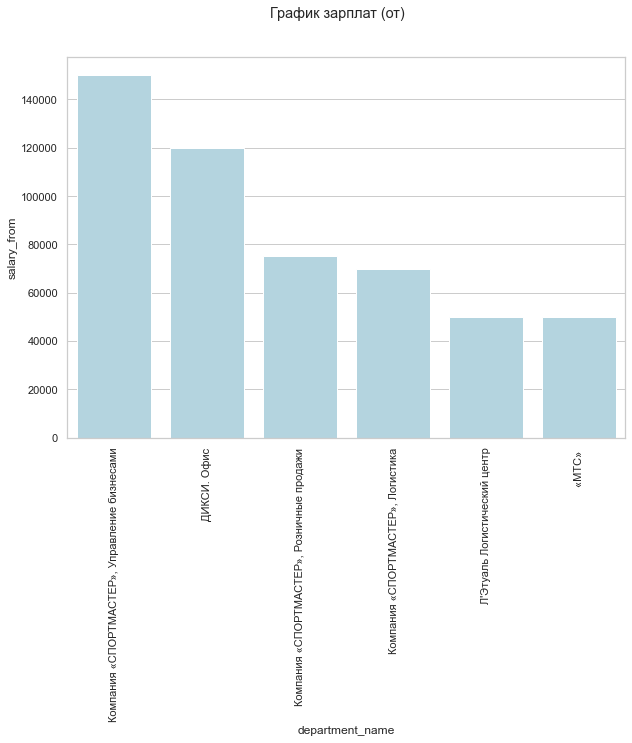

In [23]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(10,7))                
title = 'График зарплат (от)'
fig.suptitle(title)
plt.xticks(rotation=90)  
sns.barplot(data=salaries.sort_values(by='salary_from', ascending=False), x='department_name', y='salary_from', color='lightblue', ax=ax)

### Давайте поищем вакансии

Сделаем срез по городам, напримен Екатеринбург

In [24]:
city_vacs = vacancy_df[vacancy_df['city'] == "Екатеринбург"]

In [25]:
city_vacs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54 entries, 92 to 1683
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        54 non-null     object 
 1   premium                   54 non-null     bool   
 2   name                      54 non-null     object 
 3   department                8 non-null      object 
 4   has_test                  54 non-null     bool   
 5   response_letter_required  54 non-null     bool   
 6   area                      54 non-null     object 
 7   salary                    8 non-null      object 
 8   type                      54 non-null     object 
 9   address                   24 non-null     object 
 10  response_url              0 non-null      object 
 11  sort_point_distance       0 non-null      object 
 12  published_at              54 non-null     object 
 13  created_at                54 non-null     object 
 14  archived 

In [26]:
city_vacs.head()

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,...,accept_temporary,experience,employer_name,department_name,salary_from,salary_to,salary_currency,salary_gross,responses,city
92,70373746,False,Разработчик DWH (DATA Engineer),None,False,False,"{'id': '3', 'name': 'Екатеринбург', 'url': 'ht...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,False,between1And3,Уральская горно-металлургическая компания,NaN,NaN,NaN,NaN,NaN,0,Екатеринбург
119,70373952,False,Разработчик BI / Аналитик,None,False,False,"{'id': '3', 'name': 'Екатеринбург', 'url': 'ht...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,False,between1And3,Уральская горно-металлургическая компания,NaN,NaN,NaN,NaN,NaN,4,Екатеринбург
145,66704022,False,Системный аналитик,None,False,False,"{'id': '3', 'name': 'Екатеринбург', 'url': 'ht...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Екатеринбург', 'street': 'улица Розы...",...,False,between1And3,VOXYS,NaN,NaN,NaN,NaN,NaN,3,Екатеринбург
170,46147513,False,Аналитик,None,False,False,"{'id': '3', 'name': 'Екатеринбург', 'url': 'ht...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Екатеринбург', 'street': 'улица Энге...",...,False,between1And3,RAKETA,NaN,NaN,NaN,NaN,NaN,8,Екатеринбург
209,69575407,False,Системный аналитик MES,"{'id': '6131-6131-tmkplus', 'name': 'ТМК++'}",False,False,"{'id': '3', 'name': 'Екатеринбург', 'url': 'ht...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,False,between1And3,Трубная Металлургическая Компания,ТМК++,NaN,NaN,NaN,NaN,1,Екатеринбург


### Посмотрим содержание вакансий

Сделаем срез вакансий по интересному нам опыту

In [27]:
vacs_df = city_vacs.copy().reset_index(drop=True).query("experience in ['noExperience', 'between1And3']")

In [29]:
vacs_df.head()

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,...,accept_temporary,experience,employer_name,department_name,salary_from,salary_to,salary_currency,salary_gross,responses,city
0,70373746,False,Разработчик DWH (DATA Engineer),None,False,False,"{'id': '3', 'name': 'Екатеринбург', 'url': 'ht...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,False,between1And3,Уральская горно-металлургическая компания,NaN,NaN,NaN,NaN,NaN,0,Екатеринбург
1,70373952,False,Разработчик BI / Аналитик,None,False,False,"{'id': '3', 'name': 'Екатеринбург', 'url': 'ht...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,False,between1And3,Уральская горно-металлургическая компания,NaN,NaN,NaN,NaN,NaN,4,Екатеринбург
2,66704022,False,Системный аналитик,None,False,False,"{'id': '3', 'name': 'Екатеринбург', 'url': 'ht...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Екатеринбург', 'street': 'улица Розы...",...,False,between1And3,VOXYS,NaN,NaN,NaN,NaN,NaN,3,Екатеринбург
3,46147513,False,Аналитик,None,False,False,"{'id': '3', 'name': 'Екатеринбург', 'url': 'ht...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Екатеринбург', 'street': 'улица Энге...",...,False,between1And3,RAKETA,NaN,NaN,NaN,NaN,NaN,8,Екатеринбург
4,69575407,False,Системный аналитик MES,"{'id': '6131-6131-tmkplus', 'name': 'ТМК++'}",False,False,"{'id': '3', 'name': 'Екатеринбург', 'url': 'ht...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,False,between1And3,Трубная Металлургическая Компания,ТМК++,NaN,NaN,NaN,NaN,1,Екатеринбург


Выведем адреса

In [28]:
vacs_df['url'].head()

0    https://api.hh.ru/vacancies/70373746?host=hh.ru
1    https://api.hh.ru/vacancies/70373952?host=hh.ru
2    https://api.hh.ru/vacancies/66704022?host=hh.ru
3    https://api.hh.ru/vacancies/46147513?host=hh.ru
4    https://api.hh.ru/vacancies/69575407?host=hh.ru
Name: url, dtype: object

С помощью библиотек json и requests получим нужную информацию, добавим магии и обобразим HTML

In [33]:
HTML(json.loads(requests.get('https://api.hh.ru/vacancies/69575407?host=hh.ru').text)['description'])

Сохраним информацию в читаемом виде

In [34]:
vacs = vacs_df['url'].apply(lambda x: HTML(json.loads(requests.get(x).text)['description'])) 

In [35]:
vacs

0     <IPython.core.display.HTML object>
1     <IPython.core.display.HTML object>
2     <IPython.core.display.HTML object>
3     <IPython.core.display.HTML object>
4     <IPython.core.display.HTML object>
5     <IPython.core.display.HTML object>
6     <IPython.core.display.HTML object>
7     <IPython.core.display.HTML object>
8     <IPython.core.display.HTML object>
9     <IPython.core.display.HTML object>
10    <IPython.core.display.HTML object>
11    <IPython.core.display.HTML object>
12    <IPython.core.display.HTML object>
13    <IPython.core.display.HTML object>
14    <IPython.core.display.HTML object>
15    <IPython.core.display.HTML object>
16    <IPython.core.display.HTML object>
17    <IPython.core.display.HTML object>
18    <IPython.core.display.HTML object>
19    <IPython.core.display.HTML object>
20    <IPython.core.display.HTML object>
21    <IPython.core.display.HTML object>
22    <IPython.core.display.HTML object>
23    <IPython.core.display.HTML object>
24    <IPython.c

### Добавим кнопку

In [55]:
button = widgets.Button(description = 'Click me')
output = widgets.Output()

display(button, output)

counter = 0
def on_clicked(b):
    with output:
        try:
            global counter
            clear_output
            print('№ вакансии: ', counter)
            display(HTML('<h1>'+str(vacs_df['name'][counter])+ ' в ' + str(vacs_df['employer_name'][counter])+ '</h1>'))
            display(vacs[counter])
            display(HTML('<a href="' + str(vacs_df['alternate_url'][counter])+ '" "target="_blank">Ссылка на вакансию</a>'))
            counter+=1
        except Exception as e:
            print('Вакансии закончились')
            
button.on_click(on_clicked)            

Button(description='Click me', style=ButtonStyle())

Output()

С помощью библиотеки BeautifulSoup извлечем данные из HTML

In [56]:
from bs4 import BeautifulSoup
vacs = vacs_df['url'].apply(lambda x: BeautifulSoup(json.loads(requests.get(x).text)['description']).get_text()) 

In [57]:
vacs[6]

'О компании Брусника — российская девелоперская компания. Специализируется на производстве и строительстве жилых многоэтажных домов, комплексном развитии городских территорий. С начала своей деятельности в 2004 году компания построила более 2 млн м2 жилья и в настоящее время реализует проекты в крупных городах Урала и Сибири, в Москве и Московской области. Брусника включена в перечень системообразующих предприятий России. Возглавляет рейтинг ЕРЗ по потребительским качествам объектов. Обладает первым в РФ международным сертификатом BREEAM уровня excellent (в жилом секторе). Все проекты компании реализуются с применением эскроу-счетов. Суть работы  Брусника ищет специалиста, который примет участие в создании инновационного продукта – онлайн-платформы для автоматизированного проектирования жилья на базе входящих потоков. Нам нужен аналитик, который хорошо понимают сферу программирования или имеют опыт живой разработки. Важно быть инициативными и вовлечёнными в процессы работы команд

In [ ]:
# pd.set_option('display.max_columns', None) #отображение всех столбцов
# pd.reset_option('max_colwidth') #вернуть по дефолту
# pd.set_option('max_colwidth', None) #максимальная ширина колонок